# ModernNLP: #6
* Discussion around tokenization-free embeddings based on [CANINE: Pre-training an Efficient Tokenization-Free Encoder for Language Representation](https://arxiv.org/abs/2103.06874) from Clark, et al.
* Notebook implements a version of the model prescribed in the paper

```
Authored by Guilherme Dinis Junior (PhD Candidate)
H1 2021
Stockholm University, Sweden
```


As dependencies, you need:
    - Tensorflow (tested with 2.4.1)
    - Pandas
    - Matplotlib

In [1]:
from urllib import request
import pathlib
import os.path
import ast
import pandas as pd
from IPython.core import display
import tensorflow as tf
import numpy as np
import random
import time

2021-07-07 21:31:53.942359: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
tf.executing_eagerly()

True

In [3]:
tf.__version__

'2.4.1'

In [4]:
BASE_DATA_URL = "https://raw.githubusercontent.com/ipavlopoulos/toxic_spans/master/data/"
FILES = ["tsd_train", "tsd_test", "tsd_trial"]

In [5]:
def download_data(base_url, files, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    for filename in files:
        uri = os.path.join(base_url, f"{filename}.csv")
        output = os.path.join(output_dir, f"{filename}.csv")
        if not os.path.exists(output):
            request.urlretrieve(uri, filename=output)


In [6]:
def load_data(path, files):
    data_frames = {}
    for filename in files:
        df = pd.read_csv(os.path.join(path, f"{filename}.csv"))
        df["spans"] = df.spans.apply(ast.literal_eval)
        data_frames[filename] = df
    return data_frames

In [7]:
data_dir = os.path.join(pathlib.Path.home(), "fs", "toxic_spans", "raw")
download_data(BASE_DATA_URL, FILES, data_dir)
dfs = load_data(data_dir, FILES)


In [8]:
dfs["tsd_trial"].head()

,spans,text
0,"[15, 16, 17, 18, 19, 27, 28, 29, 30, 31]",Because he's a moron and a bigot. It's not any...
1,"[29, 30, 31, 32, 33, 34]",How about we stop protecting idiots and let na...
2,"[166, 167, 168, 169, 170, 171]","If people were smart, they would Boycott th..."
3,"[87, 88, 89, 90, 91, 92]",Trump Claimed that Russia will never invade th...
4,[],As long as your willing to pay a lot more for ...


In [9]:
dfs["tsd_train"].shape

(7939, 2)

In [10]:
max_text_len = max([dfs[key].text.apply(lambda x: len(x)).max() for key in FILES])

In [11]:
max_text_len 

1000

<AxesSubplot:ylabel='Frequency'>

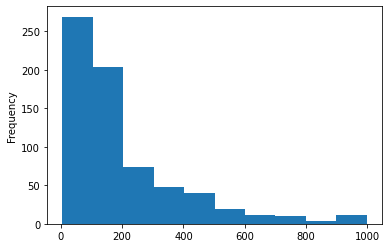

In [12]:
dfs["tsd_trial"].text.apply(lambda x: len(x)).plot.hist() 

In [13]:
min_text_len = min([dfs[key].text.apply(lambda x: len(x)).min() for key in FILES])

In [14]:
min_text_len

4

In [15]:
example_one_spans, example_one_text = dfs["tsd_trial"].spans[0], dfs["tsd_trial"].text[0]

In [16]:
def highlight_text(spans, text):
    spans_set = set(spans)
    string = []
    for i in range(len(text)):
        if i in spans_set:
            string.append(f"<span style=\"color:#FF0000;\">{text[i]}</span>")
        else:
            string.append(text[i])
    paragraph = "".join(string)
    return display.display(display.HTML(f"<p>{paragraph}</p>"))


In [17]:
highlight_text(example_one_spans, example_one_text)

# Data Processing

In [18]:
MLM_MASK_RATE = 0.15
MASK_UNICODE = ord('\x00')
PAD_UNICODE = ord('\x01')

In [19]:
def encode_text_as_unicode(text):
    return [ord(char) for char in text]

In [20]:

def encode_data_as_unicode(dataframe: pd.DataFrame):
    inputs = dataframe.text.apply(encode_text_as_unicode).values.tolist()
    spans = dataframe.spans.values.tolist()
    return inputs, spans

In [21]:
data = {key: encode_data_as_unicode(dataframe) for key, dataframe in dfs.items()}

In [22]:
def unicode_vocabulary(data):
    # mask char will be unicode 0
    codes = set([MASK_UNICODE, PAD_UNICODE])
    for _, (inputs, _) in data.items():
        for text_code in inputs:
            codes.update(text_code)
    return {code: index for index, code in enumerate(codes)}


In [23]:
vocabulary = unicode_vocabulary(data)

In [24]:
len(vocabulary)

159

In [25]:
def create_masked_language_task_example(text_unicode, mask_rate: float, mask_unicode: int):
    size = len(text_unicode)
    max_chars = int(size * mask_rate)
    # at least one char
    start_index = random.randint(0, size - 1)
    end_index = min(start_index + max_chars, size)
    example = text_unicode[0:start_index] + [mask_unicode]*(end_index - start_index) + text_unicode[end_index:]
    target = text_unicode[start_index:end_index]
    return example, target

In [26]:
def pad_sequence(sequence, max_text_len: int, pad_code: int):
    padding = max_text_len - len(sequence)
    return np.concatenate([sequence, [pad_code]*padding]).tolist()

In [27]:
def generate_masked_language_task_data(inputs, max_text_len: int, mask_rate: float, mask_unicode: int, pad_code: int, vocabulary):
    # choose a starting point
    # select at most 15% of contiguous characters to ommit
    examples_and_targets = [create_masked_language_task_example(input_, mask_rate, mask_unicode) for input_ in inputs]
    padded_data = []
    for example, target in examples_and_targets:
        # can be empty
        if target:
            try:
                padded_masked_example = pad_sequence(example, max_text_len, pad_code)
                padded_target = pad_sequence(target, int(max_text_len * mask_rate), pad_code)
                true_example = masked_example_to_text_unicode(padded_masked_example, padded_target)
                padded_true_example = pad_sequence(true_example, max_text_len, PAD_UNICODE)
                # convert uni code to class ID
                padded_true_example = [vocabulary[code] for code in padded_true_example]
                yield padded_masked_example, padded_target, padded_true_example
            except Exception:
                pass



In [28]:
def create_masked_language_task_dataset(inputs, max_text_len: int, vocabulary, mask_rate: float = MLM_MASK_RATE, mask_unicode: int = MASK_UNICODE, pad_code: int = PAD_UNICODE):
    generator = generate_masked_language_task_data(inputs, max_text_len, mask_rate, mask_unicode, pad_code, vocabulary)
    dataset = tf.data.Dataset.from_generator(lambda: generator, output_signature=(
         tf.TensorSpec(shape=(None,), dtype=tf.int32),
         tf.TensorSpec(shape=(None,), dtype=tf.int32),
         tf.TensorSpec(shape=(None,), dtype=tf.int32)))
    return dataset

In [29]:
datasets = {key: create_masked_language_task_dataset(inputs, max_text_len, vocabulary) for key, (inputs, _) in data.items()}

2021-07-07 21:31:55.843276: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-07-07 21:31:55.843918: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-07-07 21:31:55.868975: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-07-07 21:31:55.869403: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2070 computeCapability: 7.5
coreClock: 1.725GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.29GiB/s
2021-07-07 21:31:55.869450: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node

In [30]:
def masked_example_to_text_unicode(example, target, pad_code: int = PAD_UNICODE):
    example = np.array(example)
    target = np.array(target)
    example = example[0:np.where(example == pad_code)[0][0]]
    target = target[0:np.where(target == pad_code)[0][0]]
    where_masked = np.where(example == 0)
    start_index = where_masked[0][0]
    end_index = where_masked[0][-1]
    return np.concatenate([example[0:start_index], target, example[end_index+1:]])



In [31]:
def unicode_to_text(text_unicode):
    return "".join([chr(code) for code in text_unicode])

In [32]:
for example, target, true in datasets["tsd_trial"].take(1):
    print(unicode_to_text(masked_example_to_text_unicode(example, target)))

Because he's a moron and a bigot. It's not any more complicated than that.


2021-07-07 21:31:56.348274: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-07-07 21:31:56.348582: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3600000000 Hz


## Encoding Data

In [33]:
NUM_BUCKETS = 16000
DIM = 768

In [34]:
def create_hash_fn(max_int: int):
    a = np.random.randint(1, max_int)
    b = np.random.randint(1, max_int)
    if a % 2 == 0:
        a += 1
    def fn(x):
        return (a * x + b) & ((1 << 32) - 1)
    return fn

In [35]:
def hash_text_unicode(hash_fn, text_unicode, num_buckets):
    return tf.map_fn(lambda x: hash_fn(x) % num_buckets, text_unicode, dtype=tf.int32)

In [36]:
def batch_hash_text_unicode(hash_fn, batch_text_unicode, num_buckets):
    return tf.map_fn(lambda x: hash_text_unicode(hash_fn, x, num_buckets), batch_text_unicode, dtype=tf.int32)

In [37]:
batch_hash_text_unicode(create_hash_fn(1232), tf.expand_dims(example, 0), NUM_BUCKETS)

<tf.Tensor: shape=(1, 1000), dtype=int32, numpy=
array([[14323, 15118, 13244, 11370, 14110, 12236, 15118, 14465,  1929,
        15118,  5024, 12236, 14465, 11370, 14465,  6614,  8488,   481,
          481,   481,   481,   481,   481,   481,   481,   481,   481,
          481,  2866,   992,  8488, 13173, 11583, 14465,  4882, 13173,
         5024, 12236, 14465,  7551,  8488, 13173, 14465, 11370,  7551,
         1858, 14465,  6614,  8488, 11299, 15118, 14465, 13244,  8488,
         6614,  9425,  5677,  2866, 13244, 11370, 13173, 15118, 14181,
        14465, 13173,  1929, 11370,  7551, 14465, 13173,  1929, 11370,
        13173, 11583,  1418,  1418,  1418,  1418,  1418,  1418,  1418,
         1418,  1418,  1418,  1418,  1418,  1418,  1418,  1418,  1418,
         1418,  1418,  1418,  1418,  1418,  1418,  1418,  1418,  1418,
         1418,  1418,  1418,  1418,  1418,  1418,  1418,  1418,  1418,
         1418,  1418,  1418,  1418,  1418,  1418,  1418,  1418,  1418,
         1418,  1418,  1418,

In [38]:
class HashingProjection(tf.keras.layers.Layer):
    def __init__(self, num_funcs: int, num_buckets: int, dim: int):
        super().__init__()
        if dim % num_funcs != 0:
            raise ValueError(f"Dimension is not divisible by number of functions: {dim} and {num_funcs}")        

        self.num_funcs = num_funcs
        self.num_buckets = num_buckets
        self.hash_functions = [create_hash_fn(2 ** 18) for _ in range(self.num_funcs)]
        self.embeddings = [
            tf.keras.layers.Embedding(input_dim=num_buckets, output_dim=int(dim / num_funcs)) for _ in range(self.num_funcs)
        ]

    def call(self, inputs):
        # inputs: (B x T)
        # hash inputs, lookup embeddings K times
        inputs_ = [batch_hash_text_unicode(hash_fn, inputs, self.num_buckets) for hash_fn in self.hash_functions]
        # concatenate K embeddings
        embeddings_ = tf.concat([emb(hash_keys) for hash_keys, emb in zip(inputs_, self.embeddings)], axis=-1)
        # outputs: (B x T x dim)
        return embeddings_
        
    def get_config(self):
        config = super().get_config()
        config.update({"num_funcs": self.num_funcs, 
                       "num_buckets": self.num_buckets,
                       "dim": self.dim})
        return config

In [39]:
hashing_projection = HashingProjection(num_funcs=8, num_buckets=NUM_BUCKETS, dim=DIM)

In [40]:
for example, target, _ in datasets["tsd_trial"].batch(2).take(1):    
    print(hashing_projection(example).shape)

(2, 1000, 768)


## Local Transformer

In [41]:
LOCAL_TFX_WINDOW_SIZE = 200

In [42]:
def expand_mask(mask: tf.Tensor, batch_size: int, seq_len: int):
    expanded = tf.expand_dims(mask, 0)
    mask_exp = tf.matmul(tf.transpose(expanded), expanded)
    tiled = tf.tile(mask_exp, multiples=[batch_size, 1])
    return tf.reshape(tiled, shape=(batch_size, seq_len, -1))

In [43]:
class LocalTransformer(tf.keras.layers.Layer):
    def __init__(self, window_size: int, key_dim: int, seq_len: int):
        super().__init__()
        if seq_len % window_size != 0:
            raise ValueError(f"Sequence length is not divisible by window size: {seq_len} and {window_size}")
        self.seq_len = seq_len           
        self.window_size = window_size
        self.num_heads = int(seq_len / window_size)
        self.attentions = [
            tf.keras.layers.MultiHeadAttention(num_heads=1, key_dim=key_dim) for _ in range(self.num_heads)
        ]
        self._masks = []
        for start_index in range(0, self.seq_len, self.window_size):
            end_index = start_index + self.window_size
            end_mask = tf.where(tf.range(self.seq_len) < end_index, True, False)
            start_mask = tf.where(tf.range(self.seq_len) >= start_index, True, False)
            mask = tf.cast(tf.math.logical_and(end_mask, start_mask), tf.int32)
            self._masks.append(mask)
    
    def call(self, inputs):
        # inputs: (B x T x key_dim)
        batch_size = tf.shape(inputs)[0]
        seq_len = tf.shape(inputs)[1]
        # compute masks ([B x T x key_dim])
        masks = [expand_mask(mask, batch_size, seq_len) for mask in self._masks]
        # compute local attention
        # attention (B x T x key_dim), weights (B x T x T)
        outputs = [
            attx(query=inputs, value=inputs, attention_mask=mask, return_attention_scores=True) 
            for attx, mask in zip(self.attentions, masks)
        ]
        # slice and gather
        attx_outputs = []
        attx_scores = []
        for start_index, output in zip(range(0, self.seq_len, self.window_size), outputs):
            end_index = start_index + self.window_size
            attx_output, attx_score = output
            attx_output_slice = attx_output[:, start_index:end_index, :]
            # second dim for scores is the head
            attx_score_slice = tf.squeeze(attx_score, 1)[:, start_index:end_index, :]
            attx_outputs.append(attx_output_slice)
            attx_scores.append(attx_score_slice)
        
        composed_attx_output = tf.concat(attx_outputs, axis=1)
        composed_attx_scores = tf.concat(attx_scores, axis=1)
        return composed_attx_output, composed_attx_scores
        
    def get_config(self):
        config = super().get_config()
        config.update({"window_size": self.window_size, 
                       "key_dim": self.key_dim,
                       "seq_len": self.seq_len})
        return config

In [44]:
local_transformer_x0 = LocalTransformer(window_size=LOCAL_TFX_WINDOW_SIZE, key_dim=DIM, seq_len=max_text_len)


In [45]:
for example, target, _ in datasets["tsd_trial"].batch(2).take(1):    
    print(local_transformer_x0(hashing_projection(example)))

2021-07-07 21:32:16.239423: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11


(<tf.Tensor: shape=(2, 1000, 768), dtype=float32, numpy=
array([[[ 6.1520922e-04, -2.2145612e-04, -2.6955013e-04, ...,
         -6.2685169e-05, -2.4571121e-04, -1.6172578e-04],
        [ 6.1520922e-04, -2.2145445e-04, -2.6954728e-04, ...,
         -6.2686653e-05, -2.4571107e-04, -1.6172473e-04],
        [ 6.1520888e-04, -2.2145588e-04, -2.6954833e-04, ...,
         -6.2685926e-05, -2.4571031e-04, -1.6172559e-04],
        ...,
        [ 2.1474310e-03, -6.5939786e-04,  1.0151086e-04, ...,
         -1.1019165e-03, -8.7780622e-04,  2.7069363e-03],
        [ 2.1474310e-03, -6.5939786e-04,  1.0151086e-04, ...,
         -1.1019165e-03, -8.7780622e-04,  2.7069363e-03],
        [ 2.1474310e-03, -6.5939786e-04,  1.0151086e-04, ...,
         -1.1019165e-03, -8.7780622e-04,  2.7069363e-03]],

       [[-3.4226646e-04, -6.5104148e-05,  6.2268588e-04, ...,
         -3.5325054e-04,  1.6773960e-05, -6.7074943e-05],
        [-3.4226506e-04, -6.5105356e-05,  6.2268606e-04, ...,
         -3.5324768e-04,  

2021-07-07 21:32:16.541449: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11


## Convolution

In [46]:
DOWNSAMPLE_DIM = int(DIM / 4)

In [47]:
class Downsampling(tf.keras.layers.Layer):
    def __init__(self, key_dim: int, strides: int):
        super().__init__()
        # It's unclear if activation was used in the paper
        self.conv = tf.keras.layers.Conv1D(filters=key_dim, kernel_size=1, strides=strides)

    def call(self, inputs):
        # inputs: (B x T x key_dim)
        return self.conv(inputs)
        
        
    def get_config(self):
        config = super().get_config()
        config.update({"target_size": self.target_size})
        return config

In [48]:
downsample = Downsampling(key_dim=DIM, strides=4)

In [49]:
for example, target, _ in datasets["tsd_trial"].batch(2).take(1):    
    outputs, _ = local_transformer_x0(hashing_projection(example))
    print(downsample(outputs))

2021-07-07 21:32:25.658865: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


tf.Tensor(
[[[ 5.10374608e-04  1.00427089e-04  9.48430461e-05 ... -8.26528703e-04
    6.43811189e-04 -1.59135775e-03]
  [ 5.10376878e-04  1.00428086e-04  9.48419838e-05 ... -8.26529867e-04
    6.43812411e-04 -1.59135996e-03]
  [ 5.10375889e-04  1.00427489e-04  9.48427332e-05 ... -8.26528994e-04
    6.43811596e-04 -1.59135822e-03]
  ...
  [-1.95375551e-03  6.80103491e-04  2.64765229e-04 ...  4.89813683e-04
    4.77149151e-04 -1.94386055e-03]
  [-1.95375551e-03  6.80103491e-04  2.64765229e-04 ...  4.89813683e-04
    4.77149151e-04 -1.94386055e-03]
  [-1.95375551e-03  6.80103491e-04  2.64765229e-04 ...  4.89813683e-04
    4.77149151e-04 -1.94386055e-03]]

 [[ 4.67280828e-04  2.04043681e-04 -1.42556569e-03 ... -1.44201797e-03
    5.02276234e-04 -7.38587230e-04]
  [ 4.67281847e-04  2.04044467e-04 -1.42556441e-03 ... -1.44201447e-03
    5.02274197e-04 -7.38585601e-04]
  [ 4.67281759e-04  2.04045355e-04 -1.42556755e-03 ... -1.44201808e-03
    5.02275303e-04 -7.38588511e-04]
  ...
  [-1.953755

## Transformer Stack

Adapted from: https://www.tensorflow.org/text/tutorials/transformer

In [50]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

In [51]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

In [52]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])

In [53]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        attn_output, _ = self.mha(value=x, key=x, query=x, attention_mask=mask, 
                                  return_attention_scores=True)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

        return out2, attn_output

In [54]:
class DecoderLayer(tf.keras.layers.Layer):
    "Note: This layer isn't used by the transformer"
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.mha2 = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)

        attn1, attn_weights_block1 = self.mha1(value=x, key=x, query=x,
                                               attention_mask=look_ahead_mask, 
                                               return_attention_scores=True)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(
            value=enc_output, key=enc_output, query=out1, attention_mask=padding_mask,
            return_attention_scores=True)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2

In [55]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        # self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding,
                                                self.d_model)

        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate)
                           for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]

        # adding embedding and position encoding.
        # x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)
        attn = None

        for i in range(self.num_layers):
            x, attn = self.enc_layers[i](x, training, mask)

        return x, attn  # (batch_size, input_seq_len, d_model)

In [56]:
class Decoder(tf.keras.layers.Layer):
    "Note: this layer isn't used by the transformer"
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        # self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):

        seq_len = tf.shape(x)[1]
        attention_weights = {}

        # x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                 look_ahead_mask, padding_mask)

            attention_weights[f'decoder_layer{i+1}_block1'] = block1
            attention_weights[f'decoder_layer{i+1}_block2'] = block2

        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights

In [57]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               target_vocab_size, pe_input, pe_target, rate=0.1):
        """
        Note: vocabulary isn't used here since
        1. Our inputs are embeddings instead of tokens
        2. This transformer has no classifier head attached
        """
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff,
                                 input_vocab_size, pe_input, rate)
        
        # Transformer only have an encoder
        # self.decoder = Decoder(num_layers, d_model, num_heads, dff,
        #                       target_vocab_size, pe_target, rate)
        # self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        enc_output, attention_weights = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
        return enc_output, attention_weights

In [58]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048,
    input_vocab_size=8500, target_vocab_size=8000,
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 38, 512), dtype=tf.float32, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36, 512), dtype=tf.float32, minval=0, maxval=200)

fn_out, attention_weights = sample_transformer(temp_input, temp_target, training=False, enc_padding_mask=None, look_ahead_mask=None, dec_padding_mask=None)

fn_out.shape, attention_weights.shape  # (batch_size, tar_seq_len, d_model)

(TensorShape([64, 38, 512]), TensorShape([64, 38, 512]))

## Deep Transformer Stack


In [59]:
class DeepTransformerStack(tf.keras.layers.Layer):
    def __init__(self, input_vocab_size: int, output_vocab_size: int,
                 num_layers: int, num_heads: int, key_dim: int, 
                 dff: int, max_input_seq: int, max_target_seq: int):
        super().__init__()
        self.input_vocab_size = input_vocab_size
        self.output_vocab_size = output_vocab_size
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.dff = dff
        self.max_input_seq = max_input_seq
        self.max_target_seq = max_target_seq
        # It's unclear if activation was used in the paper
        self.transformer = Transformer(
            num_layers=num_layers, d_model=key_dim, num_heads=num_heads, 
            dff=dff, input_vocab_size=input_vocab_size, 
            target_vocab_size=output_vocab_size,
            pe_input=max_input_seq, pe_target=max_target_seq
        )


    def call(self, inputs, targets, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        # inputs: (B x T' x key_dim)
        return self.transformer(inp=inputs, 
                                tar=targets, 
                                training=training, 
                                enc_padding_mask=enc_padding_mask, 
                                look_ahead_mask=look_ahead_mask, 
                                dec_padding_mask=dec_padding_mask)
        
        
    def get_config(self):
        config = super().get_config()
        config.update({
            "input_vocab_size": self.input_vocab_size,
            "output_vocab_size": self.output_vocab_size,
            "num_layers": self.num_layers,
            "num_heads": self.num_heads,
            "key_dim": self.key_dim,
            "dff": self.dff,
            "max_input_seq": self.max_input_seq,
            "max_target_seq": self.max_target_seq,
        })
        return config



In [60]:
deep_transformer = DeepTransformerStack(
    input_vocab_size=len(vocabulary), 
    output_vocab_size=len(vocabulary),
    num_layers=2, 
    num_heads=2,
    key_dim=DIM,
    dff=DIM,
    max_input_seq=max_text_len, 
    max_target_seq=max_text_len
)


In [61]:
for example, target, _ in datasets["tsd_trial"].batch(2).take(1):    
    outputs, _ = local_transformer_x0(hashing_projection(example))
    outputs = downsample(outputs)
    # dtf_inputs, dtf_targets = outputs[:, 0:-1, :], outputs[:, 1:, :]
    # unclear what the decoder input is (or if it's used)
    dtf_inputs, dtf_targets = outputs, outputs
    outputs, _ = deep_transformer(dtf_inputs, dtf_targets,
                                  enc_padding_mask=None,
                                  look_ahead_mask=None,
                                  dec_padding_mask=None)
    print(outputs.shape)

(2, 250, 768)


## Upsampling


In [62]:
class Upsample(tf.keras.layers.Layer):
    def __init__(self, multiplier: int, key_dim: int):
        super().__init__()
        self.multiplier = multiplier
        self.key_dim = key_dim
        self.conv = tf.keras.layers.Conv1D(filters=key_dim, kernel_size=1, strides=1)

    def call(self, inputs, h_init):
        # inputs: (B x T' x key_dim)
        batch_size = tf.shape(inputs)[0]
        seq_len = tf.shape(inputs)[1]
        tiled = tf.tile(inputs, multiples=[1, self.multiplier, 1])
        reshaped = tf.reshape(tiled, (batch_size, seq_len * self.multiplier, -1))
        upsampled = tf.concat([h_init, reshaped], axis=-1)
        return self.conv(upsampled)
        
        
    def get_config(self):
        config = super().get_config()
        config.update({"multiplier": self.multiplier,
                       "key_dim": self.key_dim})
        return config
    

In [63]:
upsample = Upsample(multiplier = 4, key_dim = DIM)

In [64]:
for example, target, _ in datasets["tsd_trial"].batch(2).take(1):    
    hinit, _ = local_transformer_x0(hashing_projection(example))
    outputs = downsample(hinit)
    # dtf_inputs, dtf_targets = outputs[:, 0:-1, :], outputs[:, 1:, :]
    # unclear what the decoder input is (or if it's used)
    dtf_inputs, dtf_targets = outputs, outputs
    outputs, _ = deep_transformer(dtf_inputs, dtf_targets,
                                  enc_padding_mask=None,
                                  look_ahead_mask=None,
                                  dec_padding_mask=None)
                                  
    outputs = upsample(outputs, hinit)
    print(outputs.shape)

(2, 1000, 768)


## Final Projection


In [65]:
final_transformer = DeepTransformerStack(
    input_vocab_size=len(vocabulary), 
    output_vocab_size=len(vocabulary),
    num_layers=1, 
    num_heads=1,
    key_dim=DIM,
    dff=DIM,
    max_input_seq=max_text_len, 
    max_target_seq=max_text_len
)


In [66]:
for example, target, _ in datasets["tsd_trial"].batch(2).take(1):    
    hinit, _ = local_transformer_x0(hashing_projection(example))
    outputs = downsample(hinit)
    # dtf_inputs, dtf_targets = outputs[:, 0:-1, :], outputs[:, 1:, :]
    # unclear what the decoder input is (or if it's used)
    dtf_inputs, dtf_targets = outputs, outputs
    outputs, _ = deep_transformer(dtf_inputs, dtf_targets,
                                  enc_padding_mask=None,
                                  look_ahead_mask=None,
                                  dec_padding_mask=None)
                                  
    outputs = upsample(outputs, hinit)
    outputs, _ = final_transformer(outputs, outputs,
                                enc_padding_mask=None,
                                look_ahead_mask=None,
                                dec_padding_mask=None)
    print(outputs.shape)

(2, 1000, 768)


In [67]:
class CANINE(tf.keras.Model):
    def __init__(self, hashing_projection, local_transformer, downsample, deep_transformer, upsample, final_transformer, vocabulary):
        super().__init__()
        self.hashing_projection = hashing_projection
        self.local_transformer = local_transformer
        self.downsample = downsample
        self.deep_transformer = deep_transformer
        self.upsample = upsample
        self.final_transformer = final_transformer

        self.classify = tf.keras.layers.Dense(units=len(vocabulary), activation="relu")

    def call(self, inputs, enc_padding_mask = None, look_ahead_mask = None, dec_padding_mask = None):
        # inputs: (B x T x key_dim)
        hashing_projection = self.hashing_projection(inputs)
        hinit, _ = self.local_transformer(hashing_projection)
        outputs = self.downsample(hinit)
        # dtf_inputs, dtf_targets = outputs[:, 0:-1, :], outputs[:, 1:, :]
        # unclear what the decoder input is (or if it's used)
        dtf_inputs, dtf_targets = outputs, outputs
        outputs, _ = self.deep_transformer(dtf_inputs, dtf_targets,
                                           enc_padding_mask=enc_padding_mask,
                                           look_ahead_mask=look_ahead_mask,
                                           dec_padding_mask=dec_padding_mask)
                                    
        outputs = upsample(outputs, hinit)
        outputs, weights = final_transformer(outputs, outputs,
                                       enc_padding_mask=enc_padding_mask,
                                       look_ahead_mask=look_ahead_mask,
                                       dec_padding_mask=dec_padding_mask)
        return outputs, weights


In [68]:
canine = CANINE(hashing_projection=hashing_projection, local_transformer=local_transformer_x0,
                downsample=downsample, deep_transformer=deep_transformer, 
                upsample=upsample, final_transformer=final_transformer,
                vocabulary=vocabulary)



In [69]:
for example, target, _ in datasets["tsd_trial"].batch(2).take(1):    
    outputs, _ = canine(example)
    print(outputs.shape)

(2, 1000, 768)


## Training


In [70]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

    # add extra dimensions to add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [71]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

In [72]:
def create_masks(inp, tar):
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)

    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)

    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask

In [73]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


In [74]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
    accuracies = tf.equal(real, tf.argmax(pred, axis=2))

    mask = tf.math.logical_not(tf.math.equal(real, 0))
    accuracies = tf.math.logical_and(mask, accuracies)

    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [75]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')
optimizer = tf.keras.optimizers.Adam()

In [76]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int32),
    tf.TensorSpec(shape=(None, None), dtype=tf.int32),
]


@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    tar = tf.cast(tar, tf.int64)
    # tar_inp = tar[:, :-1]
    # tar_real = tar[:, 1:]

    # enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
    # print(enc_padding_mask.shape, combined_mask.shape, dec_padding_mask.shape)

    with tf.GradientTape() as tape:
        # print(inp.shape, tar.shape)
        predictions, _ = canine(inp,
                                enc_padding_mask=None,
                                look_ahead_mask=None,
                                dec_padding_mask=None)
        logits = canine.classify(predictions)
        # print(predictions.shape)
        # reconstruct original example
        loss = loss_function(tar, logits)

    gradients = tape.gradient(loss, canine.trainable_variables)
    optimizer.apply_gradients(zip(gradients, canine.trainable_variables))

    train_loss(loss)
    train_accuracy(accuracy_function(tar, logits))

In [77]:
checkpoint_path = "./job_dir"
ckpt = tf.train.Checkpoint(canine=canine,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)


In [78]:
for epoch in range(3):
    start = time.time()
    
    # because we create the ds from a generator, it can only be iterated over once
    # bar using Dataset.repeat, relingquishing control of epochs
    datasets = {key: create_masked_language_task_dataset(inputs, max_text_len, vocabulary) for key, (inputs, _) in data.items()}
    train_loss.reset_states()
    train_accuracy.reset_states()
    # Adjust batch size based on hardware
    for (batch, (inp, _, tar)) in enumerate(datasets["tsd_train"].batch(8)):
        train_step(inp, tar)

        if batch % 100 == 0:
            print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

    if (epoch + 1) % 2 == 0:
        ckpt_save_path = ckpt_manager.save()
        print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')

    print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')
    print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

Instructions for updating:
Use fn_output_signature instead
Epoch 1 Batch 0 Loss 5.7964 Accuracy 0.0008
Epoch 1 Batch 100 Loss 5.0341 Accuracy 0.0212
Epoch 1 Batch 200 Loss 4.8786 Accuracy 0.0514
Epoch 1 Batch 300 Loss 4.0617 Accuracy 0.2094
Epoch 1 Batch 400 Loss 3.6258 Accuracy 0.2931
Epoch 1 Batch 500 Loss 3.1966 Accuracy 0.3800
Epoch 1 Batch 600 Loss 3.0118 Accuracy 0.4163
Epoch 1 Batch 700 Loss 2.8716 Accuracy 0.4436
Epoch 1 Batch 800 Loss 2.7753 Accuracy 0.4625
Epoch 1 Batch 900 Loss 2.6986 Accuracy 0.4776
Epoch 1 Loss 2.6392 Accuracy 0.4894
Time taken for 1 epoch: 6500.13 secs

Epoch 2 Batch 0 Loss 2.6067 Accuracy 0.5170
Epoch 2 Batch 100 Loss 2.0123 Accuracy 0.6112
Epoch 2 Batch 200 Loss 2.0397 Accuracy 0.6060
Epoch 2 Batch 300 Loss 2.0400 Accuracy 0.6058
Epoch 2 Batch 400 Loss 2.0444 Accuracy 0.6054
Epoch 2 Batch 500 Loss 2.0340 Accuracy 0.6074
Epoch 2 Batch 600 Loss 2.0428 Accuracy 0.6059
Epoch 2 Batch 700 Loss 2.0408 Accuracy 0.6061
Epoch 2 Batch 800 Loss 2.0481 Accuracy 0.60

In [79]:
canine

Things to experiment with:
  - Make softmax more efficient (focus only on targets to be predicted)
  - Compare expansion > compression > expansion with simpler modules in the middle
  - Train downstream tasks - e.g. toxic span
  
